In [1]:
import numpy as np
from sklearn.datasets import make_sparse_spd_matrix
from scipy import linalg as LA
import random
import pandas as pd
import time

from infoband.band_info import InfoCorrBand
from wlpy.covariance import Covariance
from utils.adpt_correlation_threshold import AdptCorrThreshold
from wlpy.gist import heatmap

In [2]:
# Covariance to Correlation
def cov2cor(S: np.ndarray):
    D = np.diag(np.sqrt(np.diag(S)))
    D_inv = np.linalg.inv(D)
    return D_inv @ S @ D_inv

In [3]:
# Self Covariance of AR(1) process
def gen_S_AR1(rho = 0.8,N = 500) -> np.ndarray:
    # generate the covariance matrix of AR(1) process
    S_block = np.zeros(shape=[N, N])
    for j in range(0, N):
        S_block = S_block + np.diag(np.ones(N-j)*(rho**j), -j) + \
        np.diag(np.ones(N-j)*(rho**j), j)
    S = S_block - np.eye(N)
    return S

In [4]:
rng = np.random.RandomState(100)
N = 100
T = 50
alpha = 0.95
rho = 0.8

In [5]:
S = gen_S_AR1(N = N, rho = rho) # structured
# S = make_sparse_spd_matrix(N, alpha = alpha, random_state = 100) # unstructured
# S[:5, :5]
X = rng.multivariate_normal(mean = np.zeros(N), cov = S, size = T)

In [6]:
c = InfoCorrBand(X)
R = cov2cor(S)
L = abs(R)
c.feed_info(L)

/home/R_PUBLIC_2021101409163534/Xiang Lu/Comention_simu/infoband/band_info.py:58: UserWarning: L-matrix is missing.
  warnings.warn('L-matrix is missing.')


/usr/local/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


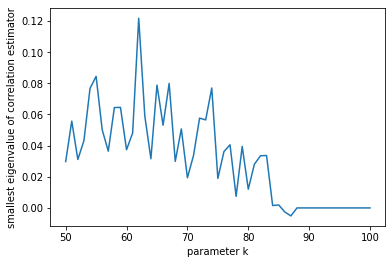

In [7]:
# c.find_biggest_k_for_pd() # I delete this method
c.plot_k_pd(range(N - 50, N + 1))

In [8]:
k = c.k_by_cv()
print(k)
R_est = c.fit_info_corr_band(k)
S_est = c.fit_info_cov_band(k)

2


In [9]:
m = Covariance(X)

In [10]:
def show_rs(S: np.ndarray, 
            c: InfoCorrBand, m: Covariance, 
            ord = 'fro'):
    # ord: norm type
    R = cov2cor(S)
    print('Correlation itself', LA.norm(R, ord))
    print('Error:')
    print('Sample', LA.norm(c.sample_corr() - R, ord))
    print('Linear Shrinkage', LA.norm(cov2cor(m.lw_lin_shrink()) - R, ord))
    print('Nonlinear Shrinkage', LA.norm(cov2cor(m.nonlin_shrink()) - R, ord))
    print()
    print('Covariance itself', LA.norm(S, ord))
    print('Error:')
    print('Sample', LA.norm(c.sample_cov() - S, ord))
    print('Linear Shrinkage', LA.norm(m.lw_lin_shrink() - S, ord))
    print('Nonlinear Shrinkage', LA.norm(m.nonlin_shrink() - S, ord))
    return

In [11]:
def gen_eta_sequence(N, eta = 0.5, draw_type = 'random', is_random = False, 
                     rand_seed = 100, near_factor = 2) -> np.ndarray:
    """
    Generate a sequence b, which is a permutation of {1, ..., N}. 
    b satisfies the property: for any 0 < k < N+1, b[0]~b[k-1] include {1, ..., ceil(eta*k)}.  
    
    draw_type : {'random', 'near'}
        Algorithms about how to draw ( {b[0], ..., b[k-1]} - {1, ..., ceil(eta*k)} ). Here '-' is a subtraction between two sets.
    is_random : bool
        If False, we use random_seed as random seed, for repeat running results.
    random_seed : int
    near_factor : float
        Needed only when draw_type = 'near'.
    """
    if is_random:
        rng = random
    else:
        rng = np.random.RandomState(rand_seed)
        
    b = [1] # Default to keep the diagonal element in covariance estimation.
    b_complement = [i for i in range(2, N + 1)] # b's complement set
    
    for k in range(2, N + 1):
        # consider k-th element
        th = int(np.ceil(eta * k))
        # S^L_k include S^d_{th}
        cnt = sum([1 if num <= th else 0 for num in b])
        if cnt < th:
            for next_id in range(1, th + 1):
                if next_id not in b:
                    b.append(next_id)
                    b_complement.remove(next_id)
                    break
        else:
            # len(b_complement) == N + 1 - k
            if draw_type == 'random':
                j = rng.randint(0, N - k) if N - k > 0 else 0
            elif draw_type == 'near':
                upper = min(int(near_factor * k), N - k)
                j = rng.randint(0, upper) if upper > 0 else 0
            else:
                raise Exception('draw_type, value error')
            next_id = b_complement[j] 
            b.append(next_id)
            b_complement.remove(next_id)
    return np.array(b)

In [12]:
def gen_L(S, eta, verbose = False, draw_type = 'random', is_random = False, 
          rand_seed = 100, near_factor = 2):
    N = S.shape[0]
    new_rowSort = np.zeros((N, N))
    
    R = cov2cor(S)
    L = abs(R)
    rowSort = InfoCorrBand(X = np.eye(N), L = L).rowSort # You can ignore the 'X = np.eye(N)' parameter. I create this temporary object solely to get 'rowSort' matrix.
    
    for i in range(N):
        row = rowSort[i]
        argst = row.argsort()
        b = gen_eta_sequence(N, eta, draw_type, is_random, rand_seed, near_factor)
        for j in range(N):
            new_rowSort[i][argst[j]] = b[j]
    
    L_eta = 1 / new_rowSort
    res = (L_eta, new_rowSort, rowSort)
    return res if verbose else L_eta

In [13]:
L1 = gen_L(S, eta = 0.5, verbose = 0, 
           draw_type = 'near', is_random = 0)
c1 = InfoCorrBand(X = X, L = L1, num_cv = 20)
k1 = c1.k_by_cv()
print(k1)
R_est1 = c1.fit_info_corr_band(k1)
S_est1 = c1.fit_info_cov_band(k1)

2


In [14]:
L2 = gen_L(S, eta = 0.5, verbose = 0, 
           draw_type = 'random', is_random = 0)
c2 = InfoCorrBand(X = X, L = L2, num_cv = 20)
k2 = c2.k_by_cv()
print(k2)
R_est2 = c2.fit_info_corr_band(k2)
S_est2 = c2.fit_info_cov_band(k2)

14


In [15]:
show_rs(S, c, m, 'fro')

Correlation itself 21.111111111111125
Error:
Sample 13.631392272290457
Linear Shrinkage 10.783726393891417
Nonlinear Shrinkage 10.645226862906256

Covariance itself 21.111111111111125
Error:
Sample 16.332019382075206
Linear Shrinkage 11.229741473572744
Nonlinear Shrinkage 11.338422177804972


In [16]:
show_rs(S, c, m, 2)

Correlation itself 8.852795603006218
Error:
Sample 6.81420141124272
Linear Shrinkage 4.436857110151969
Nonlinear Shrinkage 4.208217168517955

Covariance itself 8.852795603006218
Error:
Sample 9.490711256619793
Linear Shrinkage 4.2920727573489925
Nonlinear Shrinkage 4.082295865771666


In [17]:
show_rs(S, c, m, 1)

Correlation itself 8.99987154770766
Error:
Sample 14.735406562129354
Linear Shrinkage 10.55475807207408
Nonlinear Shrinkage 10.829088456036908

Covariance itself 8.99987154770766
Error:
Sample 21.92013831918438
Linear Shrinkage 11.95183095432187
Nonlinear Shrinkage 11.972333459059646


In [18]:
c.rowSort[5][:10]
c1.rowSort[5][:20]
c2.rowSort[5][:10]

array([ 86.,   9.,  74.,   4.,   2.,   1.,   3.,   5.,   8., 100.])

In [19]:
for ord in ['fro', 2, 1]:
    print(ord, 'cor')
    print(LA.norm(R - R_est, ord))
    print(LA.norm(R - R_est1, ord))
    print(LA.norm(R - R_est2, ord))
    print(ord, 'cov')
    print(LA.norm(S - S_est, ord))
    print(LA.norm(S - S_est1, ord))
    print(LA.norm(S - S_est2, ord))

fro cor
18.17656800031803
17.678222641752292
8.63246380232672
fro cov
18.371017032695438
17.89300133245338
10.419181136830463
2 cor
7.681488133857938
7.421961037784551
2.963289831857972
2 cov
7.565375948897135
7.272989583976607
2.927967808518803
1 cor
7.999871547707659
7.999851958733077
5.123945300005908
1 cov
8.672489460621778
8.672489460621778
7.572673843546061


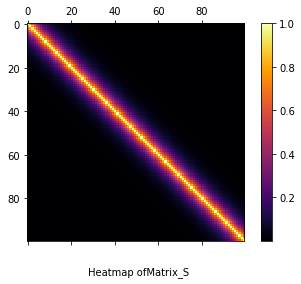

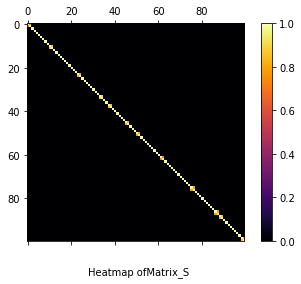

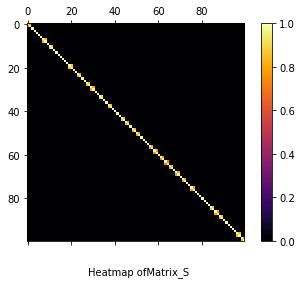

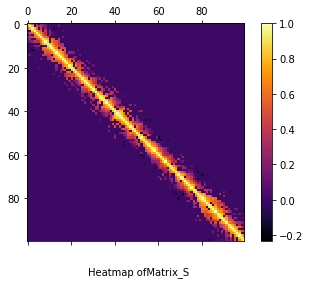

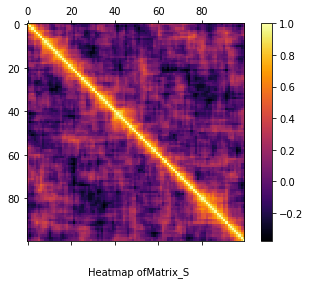

In [20]:
heatmap(R)
heatmap(R_est)
heatmap(R_est1)
heatmap(R_est2)
heatmap(c.sample_corr())

In [21]:
c.auto_fit()

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([[1.06586502, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.94005854, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.94930403, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.98563935, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 1.03406977,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.50893011]]),
 1)

In [22]:
class time_printer():
    def __init__(self):
        self.t = time.time()
        self.t_next = None
        
    def tick(self):
        self.t_next = time.time()
        print("    Time Interval: {}".format(self.t_next - self.t))
        self.t = self.t_next

In [23]:
is_random = False
rng = (random if is_random else np.random.RandomState(100)) # 300_300:101. other: 100
N = 400
T = 300
res = []
rho_range = [0.8, 0.9, 0.95, 0.99]
eta_range = [0.5, 0.8, 1]
ord_range = ['fro', 2]
near_factor_range = [0.5, 2]
tp = time_printer()

In [ ]:
print(N, T)
for rho in rho_range:
    print("rho: ", rho)
    
    S = gen_S_AR1(rho = rho, N = N)
    R = cov2cor(S)
    X = rng.multivariate_normal(mean = np.zeros(N), cov = S, size = T)
    
    m = Covariance(X)
    S_l = m.lw_lin_shrink()
    R_l = cov2cor(S_l)
    S_nl = m.nonlin_shrink()
    R_nl = cov2cor(S_nl)
    
    tp.tick()
    
    for eta in eta_range:
        for near_factor in near_factor_range:
            print("eta, near_factor: ", eta, near_factor)
            
            L = gen_L(S, eta, 
                draw_type = 'near', 
                is_random = is_random, 
                near_factor = near_factor)   
            
            tp.tick()
                
            c = InfoCorrBand(X, L)
            
            tp.tick()
            
            R_est, S_est = c.auto_fit()[:2]
            
            tp.tick()
            
            for ord in ord_range:   
                print("ord: ", ord)
                
                dct_cov = {'group': 'S', 
                    'norm type': ord, 
                    'rho': rho, 
                    'eta': eta, 
                    'near factor': near_factor, 
                    'S or R': LA.norm(S, ord), 
                    'Sample': LA.norm(c.sample_cov() - S, ord), 
                    'Linear Shrinkage': LA.norm(S_l - S, ord), 
                    'Nonlinear Shrinkage': LA.norm(S_nl - S, ord), 
                    'Info Band': LA.norm(S_est - S, ord)}
                dct_cor = {'group': 'R', 
                    'norm type': ord, 
                    'rho': rho, 
                    'eta': eta, 
                    'near factor': near_factor, 
                    'S or R': LA.norm(R, ord), 
                    'Sample': LA.norm(c.sample_corr() - R, ord), 
                    'Linear Shrinkage': LA.norm(R_l - R, ord), 
                    'Nonlinear Shrinkage': LA.norm(R_nl - R, ord), 
                    'Info Band': LA.norm(R_est - R, ord)}
                res += [dct_cov, dct_cor]
                
                tp.tick()

400 300
rho:  0.8
    Time Interval: 4.489145994186401
eta, near_factor:  0.5 0.5
    Time Interval: 4.14154052734375
    Time Interval: 0.07994866371154785


In [ ]:
df = pd.DataFrame(res)
df

In [ ]:
path = 'resultData/'
file_name = 'result_' + str(N) + '-' + str(T) + '.csv'
df.to_csv(path + file_name)
# df.to_csv(path + file_name, float_format = '%.5f') 

dataframe 追加模式 https://blog.csdn.net/lost0910/article/details/105321888

# test

In [ ]:
N = 400
T = 400
S = gen_S_AR1(rho = 0.9, N = N)
R = cov2cor(S)
X = np.random.multivariate_normal(mean = np.zeros(N), cov = S, size = T)
m = Covariance(X)
S_nl = m.nonlin_shrink()
print(S_nl)
lam, u = np.linalg.eigh(m.sample_cov())
print(lam)